# Applying the data_block API

In [4]:
from fastai import *
from fastai.vision import *

In [6]:
path = Path('data/aircrafts')

In [7]:
path.ls()
# (path/'train').ls()
# (path/'test').ls()

[PosixPath('data/aircrafts/valid'),
 PosixPath('data/aircrafts/train'),
 PosixPath('data/aircrafts/.ipynb_checkpoints')]

**Transformations**  
We can get a lot more specific with this. For example, for satellite images you can use  
`planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)`

In [8]:
tfms = get_transforms(do_flip=False)

In [9]:
data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

Alternatively, split by random instead of by folder using split_by_rand_pct()

In [10]:
data = (ImageList.from_folder(path) #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct() #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_folder() #How to label?
        .transform(tfms, size=64) #Data augmentation? -> use tfms with a size of 128
        .databunch())             #Finally -> use the defaults for conversion to databunch

We can also split up the source and the data itself  
and normalize using these `imagenet_stats`

In [48]:
np.random.seed(42)
src = (ImageList.from_folder(path)
       .split_by_folder()
       .label_from_folder())

In [49]:
data = (src.transform(tfms, size=64)
       .databunch().normalize(imagenet_stats))

## View data

Look at the data from the created databunch

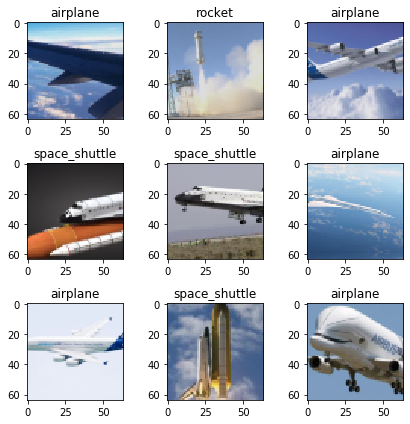

In [50]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [12]:
data.c

3

Classes are inferred from folder names

In [51]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)
# data.valid_ds.classes
# data.train_ds.classes

(['airplane', 'rocket', 'space_shuttle'], 3, 574, 69)

In [52]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['airplane', 'rocket', 'space_shuttle'], 3, 574, 69)

## Train model

In [53]:
arch = models.resnet50

In [54]:
learn = cnn_learner(data, arch, metrics=accuracy)

In [55]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


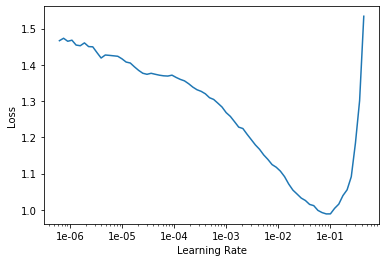

In [56]:
lr_find(learn)
learn.recorder.plot()

In [57]:
lr = 0.01

In [58]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.180819,1.199547,0.652174,00:02
1,1.038827,0.602434,0.782609,00:02
2,0.904650,0.416459,0.869565,00:02
3,0.836285,0.338431,0.840580,00:02
4,0.753215,0.325839,0.869565,00:02


In [59]:
learn.save('stage-1-rn50')

In [60]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


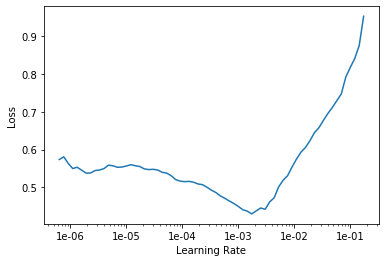

In [61]:
learn.lr_find()
learn.recorder.plot()

In [62]:
learn.fit_one_cycle(5, slice(1e-3, lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.597576,0.549578,0.884058,00:02
1,0.591470,3.280010,0.710145,00:02
2,0.569948,1.699371,0.753623,00:02
3,0.510677,0.272840,0.898551,00:02
4,0.451386,0.197163,0.927536,00:02


In [63]:
learn.save('stage-2-rn50')

In [64]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


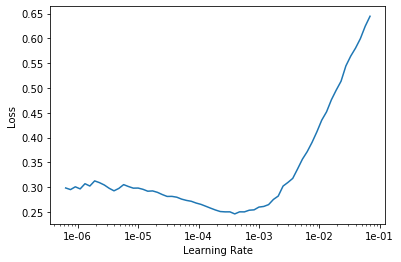

In [65]:
learn.lr_find()
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(5, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.253708,0.077221,0.971014,00:02
1,0.245214,0.251738,0.927536,00:02
2,0.259293,0.092435,0.956522,00:02
3,0.270221,0.103064,0.956522,00:02
4,0.246134,0.103755,0.956522,00:02


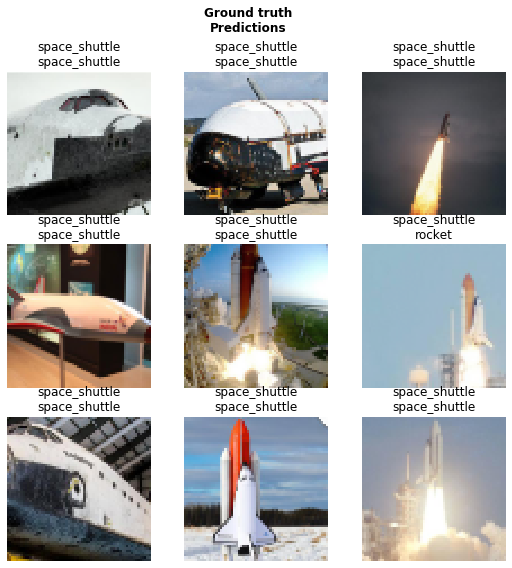

In [67]:
learn.show_results(rows=3, figsize=(9,9))

## Interpretation

In [69]:
learn.load('stage-2-rn50');

In [70]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

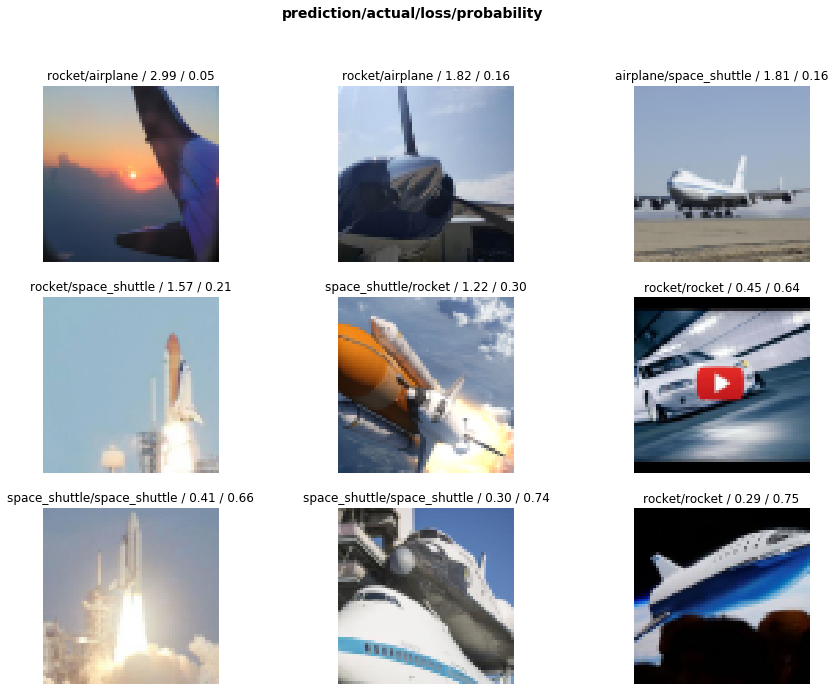

In [71]:
interp.plot_top_losses(9, figsize=(15,11))

In [73]:
interp.most_confused()

[('airplane', 'rocket', 2),
 ('rocket', 'space_shuttle', 1),
 ('space_shuttle', 'airplane', 1),
 ('space_shuttle', 'rocket', 1)]

Try with `learn.predict()` using an actual image.  
Steps taken from https://github.com/npatta01/web-deep-learning-classifier/blob/master/notebooks/1_train.ipynb

In [89]:
plane_url = "https://upload.wikimedia.org/wikipedia/commons/5/5e/ANA_777-300_Taking_off_from_JFK.jpg"

In [90]:
url = plane_url

In [91]:
def fetch_image(url):
    response = requests.get(url)
    img = open_image(BytesIO(response.content))
    return img

In [92]:
img = fetch_image(plane_url)
pred_class, pred_idx, outputs = learn.predict(img)
pred_class, pred_idx, outputs

(Category airplane, tensor(0), tensor([0.9839, 0.0039, 0.0122]))

In [95]:
import pprint
def predict(url):
    img = fetch_image(url)
    pred_class,pred_idx,outputs = learn.predict(img)
    res =  zip (learn.data.classes, outputs.tolist())
    predictions = sorted(res, key=lambda x:x[1], reverse=True)
    top_predictions = predictions[0:5]
    pprint.pprint(top_predictions)
    return img.resize(500)

[('airplane', 0.9839030504226685),
 ('space_shuttle', 0.012163753621280193),
 ('rocket', 0.003933195490390062)]


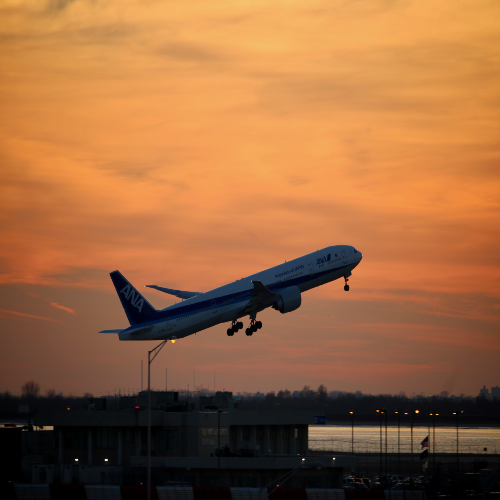

In [96]:
predict(plane_url)